In [1]:
import numpy as np
from numba import cuda
import time
import os
import math
from matplotlib import pyplot as plt
%matplotlib inline

0  GPU time  1.455458164215088
1  GPU time  0.2952115535736084
2  GPU time  0.3231780529022217
3  GPU time  0.35808801651000977
4  GPU time  0.40392613410949707
5  GPU time  0.44286298751831055
6  GPU time  0.47572779655456543
7  GPU time  0.5096690654754639
8  GPU time  0.5405988693237305
9  GPU time  0.5704774856567383
10  GPU time  0.6003944873809814
11  GPU time  0.6323513984680176
12  GPU time  0.6662623882293701
13  GPU time  0.6911895275115967
14  GPU time  0.7140960693359375
15  GPU time  0.7370302677154541
16  GPU time  0.7679481506347656
17  GPU time  0.7959182262420654
18  GPU time  0.8388168811798096
19  GPU time  0.8647313117980957
20  GPU time  0.9006397724151611
21  GPU time  0.9305126667022705
22  GPU time  0.9584379196166992
23  GPU time  0.9833712577819824
24  GPU time  0.9993634223937988
25  GPU time  1.0083119869232178
26  GPU time  1.0163307189941406
27  GPU time  1.0272529125213623
28  GPU time  1.0332863330841064
29  GPU time  1.039222002029419
30  GPU time  1.04

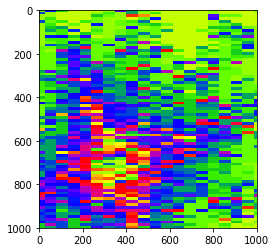

In [3]:
@cuda.jit(device=True)
def mandelbrot(r, im, max_iters):
    c = complex(r, im)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return max_iters
            
@cuda.jit            
def kernel(min_x, min_y, pixel_size_x, pixel_size_y, width, height, image, max_iters): 
    idx_x, idx_y = cuda.grid(2)
    
    r = min_x + idx_x * pixel_size_x
    im = min_y + idx_y * pixel_size_y
    if idx_x < width and idx_y < height:
        image[idx_y, idx_x] = mandelbrot(r, im, max_iters)  
    

ittr = 500
padding = 1.5
x = -0.777807810193171
y = 0.131645108003206
max_iters = 5000
reduce_coef = 1.06

cmap = plt.cm.prism

output_folder = "output"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i in range(ittr):
    image = np.zeros((1000, 1000), dtype = np.double)
   
    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(image.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(image.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    
    height = image.shape[0]
    width = image.shape[1]
    
    grid_x = blockspergrid_x * threadsperblock[1]
    grid_y = blockspergrid_y * threadsperblock[0]    
    
    pixel_size_x = 2 * padding / width
    pixel_size_y = 2 * padding / height
    
    min_x = x - padding
    min_y = y - padding

    start = time.time()
    d_image = cuda.to_device(image)

    kernel[blockspergrid, threadsperblock](min_x, min_y, pixel_size_x, pixel_size_y, width, height, d_image, max_iters)

    d_image.to_host()
    dt = time.time() - start
        
    padding /= reduce_coef    

    print (i, " GPU time ", dt)
    
    plt.imsave(fname="output/image" + str(i) + ".jpg", arr=image, cmap=cmap, vmin=0, vmax=max_iters)
     
plt.imshow(image, cmap=cmap, vmin=0)

In [2]:
import cv2

In [10]:
ittr = 550

video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 24, (1000, 1000))

for i in range(ittr):
    img = cv2.imread("output/image" + str(i) + ".jpg")
    video_writer.write(img)
    
cv2.destroyAllWindows()
video_writer.release()